In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim.lr_scheduler as lr_scheduler

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [138]:
# Define transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomCrop(48, padding=5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/images/train", transform=transform)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

validation_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/images/validation", transform=transform)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


In [139]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*3*3, 512),
            nn.ReLU(),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x


In [143]:
# Initialize model, loss, and optimizer
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Apply label smoothing
# Optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # Adjust for epochs



def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def train_part(model, optimizer, epochs=10):
    model = model.to(device)
    for epoch in range(epochs):
        print("Epoch:", epoch + 1)
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()
        for images, labels in loaded_train:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loaded_train):.4f}, Accuracy: {accuracy:.2f}%")
        scheduler.step()
        
print("Starting training...")
train_part(model, optimizer, epochs=50)
print("Training complete!")

val_accuracy = evaluate_model(model, loaded_validation)
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Starting training...
Epoch: 1
Epoch 1/50, Loss: 1.8760, Accuracy: 24.59%
Epoch: 2
Epoch 2/50, Loss: 1.6785, Accuracy: 35.82%
Epoch: 3
Epoch 3/50, Loss: 1.5091, Accuracy: 46.10%
Epoch: 4
Epoch 4/50, Loss: 1.4338, Accuracy: 50.07%
Epoch: 5
Epoch 5/50, Loss: 1.3830, Accuracy: 53.00%
Epoch: 6
Epoch 6/50, Loss: 1.3472, Accuracy: 55.31%
Epoch: 7
Epoch 7/50, Loss: 1.3187, Accuracy: 56.50%
Epoch: 8
Epoch 8/50, Loss: 1.2920, Accuracy: 58.03%
Epoch: 9
Epoch 9/50, Loss: 1.2658, Accuracy: 59.67%
Epoch: 10
Epoch 10/50, Loss: 1.2509, Accuracy: 60.34%
Epoch: 11
Epoch 11/50, Loss: 1.2317, Accuracy: 61.06%
Epoch: 12
Epoch 12/50, Loss: 1.2155, Accuracy: 62.27%
Epoch: 13
Epoch 13/50, Loss: 1.2011, Accuracy: 62.79%
Epoch: 14
Epoch 14/50, Loss: 1.1877, Accuracy: 63.48%
Epoch: 15
Epoch 15/50, Loss: 1.1737, Accuracy: 64.19%
Epoch: 16
Epoch 16/50, Loss: 1.1636, Accuracy: 65.12%
Epoch: 17
Epoch 17/50, Loss: 1.1493, Accuracy: 65.91%
Epoch: 18
Epoch 18/50, Loss: 1.1361, Accuracy: 66.36%
Epoch: 19
Epoch 19/50, Lo

Target label: sad


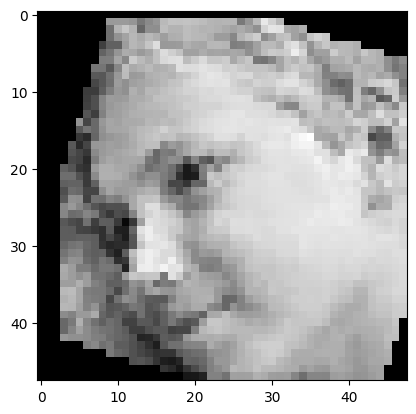

In [141]:
# Visualization setup
dataiter = iter(loaded_train)
images, labels = next(dataiter)
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display a random image and its label
random_idx = random.randint(0, 63)
print("Target label:", expression[int(labels[random_idx].cpu().numpy())])
plt.imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()


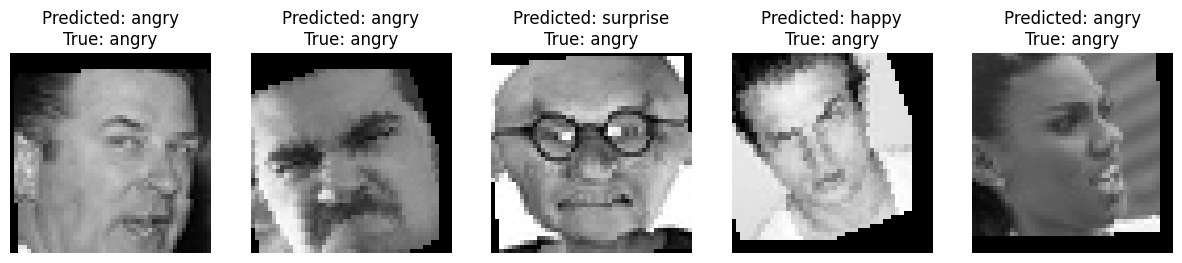

In [142]:
# Evaluate the model and make predictions on 5 random images
model.eval()
dataiter = iter(loaded_validation)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display 5 random images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_idx = random.randint(0, len(images) - 1)
    axes[i].imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Predicted: {expression[int(predicted[random_idx].cpu().numpy())]}\nTrue: {expression[int(labels[random_idx].cpu().numpy())]}")
    axes[i].axis('off')
plt.show()